# Hyper-parameter scans

Here we consider how different optimization algorithms behave (for this system) and how their hyper parameters influence the resulting cluster expansion.
We use the cutoffs `[8.0, 6.5, 6.0]` and consider the following optimization algorithms

* ARDR (Automatic Relevance Determination Regression)
* RFE (Recursive Feature Elimination)
* LASSO (Least Absolute Shrinkage and Selection Operator)
* Adaptive-LASSO

From the analyis above one can conclude that around 20 to 30 non-zero ECIs are a good choice with cutoffs `[8.0, 6.5, 6.0]`.
We also note here that LASSO performs quite poorly compared to the other methods, whereas the other three methods all yield similar results.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ase.db import connect
from icet import ClusterSpace, StructureContainer
from trainstation import CrossValidationEstimator

try:
    import seaborn as sns
    sns.set_context('notebook')
except ImportError:
    print('sad')


def get_row(cve):
    row = dict()
    row['rmse_validation'] = cve.rmse_validation
    row['rmse_train'] = cve.rmse_train
    row['BIC'] = cve.model.BIC
    row['n_parameters'] = cve.n_parameters
    row['n_nonzero_parameters'] = cve.n_nonzero_parameters
    return row


In [2]:
# parameters
cutoffs = [8.0, 6.5, 6.0]

# setup CS and get fit data
db = connect('../../tutorial/reference_data.db')
primitive_structure = db.get(id=1).toatoms()  # primitive structure

cs = ClusterSpace(structure=primitive_structure, cutoffs=cutoffs, chemical_symbols=['Ag', 'Pd'])
sc = StructureContainer(cluster_space=cs)
for row in db.select():
    sc.add_structure(structure=row.toatoms(), user_tag=row.tag,
                     properties={'mixing_energy': row.mixing_energy})
A, y = sc.get_fit_data(key='mixing_energy')

## Scanning ARDR hyper-parameter
ARDR has the hyper-parameter `threshold-lambda` which controls the sparsity of the solution.

In [3]:
# scan ARDR
lambda_values = [250, 500, 1000, 1400, 2000, 2500, 4500, 7500, 13000, 18000, 25000, 40000, 60000, 90000, 200000]
records = []
for lam in lambda_values:
    cve = CrossValidationEstimator((A, y), fit_method='ardr', threshold_lambda=lam)
    cve.validate()
    cve.train()
    row = get_row(cve)
    row['threshold_lambda'] = lam
    records.append(row)
df_ardr = pd.DataFrame(records)

## Scanning RFE hyper-parameter
RFE has the hyper-parameter `n_features` which controls the sparsity of the solution.

In [4]:
nf_values = np.arange(10, len(cs), 4)
records = []
for nf in nf_values:
    cve = CrossValidationEstimator((A, y), fit_method='rfe', n_features=nf)
    cve.validate()
    cve.train()
    row = get_row(cve)
    print(row)
    records.append(row)
df_rfe = pd.DataFrame(records)

{'rmse_validation': 0.002798344450116252, 'rmse_train': 0.002683403161977985, 'BIC': -7354.707739792168, 'n_parameters': 64, 'n_nonzero_parameters': 10}
{'rmse_validation': 0.0023145778033947244, 'rmse_train': 0.0021922571247087823, 'BIC': -7570.183866056698, 'n_parameters': 64, 'n_nonzero_parameters': 14}
{'rmse_validation': 0.0021973373681505614, 'rmse_train': 0.0020374384922598526, 'BIC': -7618.165863997955, 'n_parameters': 64, 'n_nonzero_parameters': 18}
{'rmse_validation': 0.0021057053328768344, 'rmse_train': 0.0019395259773153275, 'BIC': -7661.051031863528, 'n_parameters': 64, 'n_nonzero_parameters': 22}
{'rmse_validation': 0.0020280745500089077, 'rmse_train': 0.0018518706714521532, 'BIC': -7685.110319218685, 'n_parameters': 64, 'n_nonzero_parameters': 26}
{'rmse_validation': 0.0020160090433279216, 'rmse_train': 0.0018127681433093307, 'BIC': -7690.311903614312, 'n_parameters': 64, 'n_nonzero_parameters': 30}
{'rmse_validation': 0.001995087671145074, 'rmse_train': 0.00178084544188

## Scanning LASSO


In [5]:
# LASSO
alpha_values = np.logspace(-5, -0.5, 20)
records = []
for alpha in alpha_values:
    cve = CrossValidationEstimator((A, y), max_iter=50000, fit_method='lasso', alpha=alpha)
    cve.validate()
    cve.train()
    row = get_row(cve)
    row['alpha'] = alpha
    print(row)
    records.append(row)
df_lasso = pd.DataFrame(records)

{'rmse_validation': 0.001968113853657245, 'rmse_train': 0.0017400585214774424, 'BIC': -7528.120330641913, 'n_parameters': 64, 'n_nonzero_parameters': 63, 'alpha': 1e-05}
{'rmse_validation': 0.00196748489187155, 'rmse_train': 0.001740075837948438, 'BIC': -7528.1128117539, 'n_parameters': 64, 'n_nonzero_parameters': 63, 'alpha': 1.725210549942039e-05}
{'rmse_validation': 0.001966399230367668, 'rmse_train': 0.0017401195325501665, 'BIC': -7521.649049770729, 'n_parameters': 64, 'n_nonzero_parameters': 64, 'alpha': 2.9763514416313192e-05}
{'rmse_validation': 0.0019647094450454014, 'rmse_train': 0.0017402294453499902, 'BIC': -7521.566491938609, 'n_parameters': 64, 'n_nonzero_parameters': 64, 'alpha': 5.1348329074375493e-05}
{'rmse_validation': 0.001961979315327377, 'rmse_train': 0.0017404941606713371, 'BIC': -7534.267236507214, 'n_parameters': 64, 'n_nonzero_parameters': 62, 'alpha': 8.858667904100833e-05}
{'rmse_validation': 0.0019579068381050295, 'rmse_train': 0.001741129678082679, 'BIC': -

In [6]:
# Adaptive - LASSO
alpha_values = np.logspace(-5, -1.5, 20)
records = []
for alpha in alpha_values:
    cve = CrossValidationEstimator((A, y), max_iter=50000, fit_method='adaptive-lasso', alpha=alpha)
    cve.validate()
    cve.train()
    row = get_row(cve)
    row['alpha'] = alpha
    print(row)
    records.append(row)
df_adlasso = pd.DataFrame(records)

{'rmse_validation': 0.0019663470998611673, 'rmse_train': 0.001740216265055334, 'BIC': -7560.272185961742, 'n_parameters': 64, 'n_nonzero_parameters': 58, 'alpha': 1e-05}
{'rmse_validation': 0.0019641902390184116, 'rmse_train': 0.0017403582897293386, 'BIC': -7560.23568024784, 'n_parameters': 64, 'n_nonzero_parameters': 58, 'alpha': 1.5283067326587687e-05}
{'rmse_validation': 0.001962023557717041, 'rmse_train': 0.0017406179609130857, 'BIC': -7566.541913746687, 'n_parameters': 64, 'n_nonzero_parameters': 57, 'alpha': 2.3357214690901213e-05}
{'rmse_validation': 0.0019606395408323166, 'rmse_train': 0.0017412436684415664, 'BIC': -7585.209905482276, 'n_parameters': 64, 'n_nonzero_parameters': 54, 'alpha': 3.5696988468260624e-05}
{'rmse_validation': 0.00196096282914115, 'rmse_train': 0.001742494457786217, 'BIC': -7597.421552630661, 'n_parameters': 64, 'n_nonzero_parameters': 52, 'alpha': 5.4555947811685143e-05}
{'rmse_validation': 0.001957241589180568, 'rmse_train': 0.0017444088173038078, 'BIC

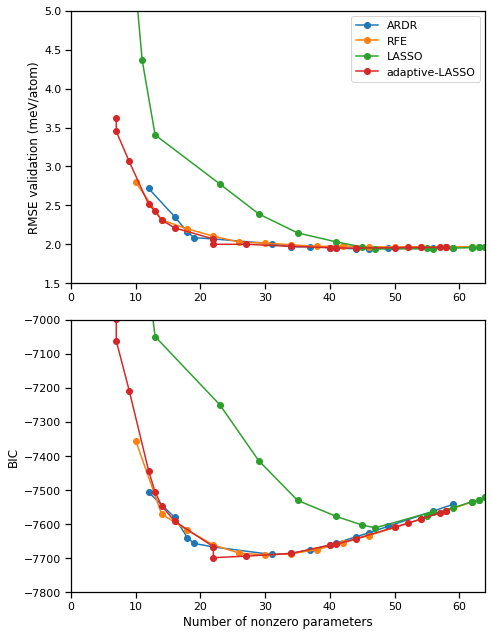

In [7]:

# Plotting
fig = plt.figure(figsize=(7, 9))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
xlim = [0, len(cs)]
ylim1 = [1.5, 5]
ylim2 = [-7800, -7000]

ax1.plot(df_ardr.n_nonzero_parameters, 1000 * df_ardr.rmse_validation, '-o', label='ARDR')
ax1.plot(df_rfe.n_nonzero_parameters, 1000 * df_rfe.rmse_validation, '-o', label='RFE')
ax1.plot(df_lasso.n_nonzero_parameters, 1000 * df_lasso.rmse_validation, '-o', label='LASSO')
ax1.plot(df_adlasso.n_nonzero_parameters, 1000 * df_adlasso.rmse_validation, '-o',
         label='adaptive-LASSO')
ax1.legend()

ax2.plot(df_ardr.n_nonzero_parameters, df_ardr.BIC, '-o', label='ARDR')
ax2.plot(df_rfe.n_nonzero_parameters, df_rfe.BIC, '-o', label='RFE')
ax2.plot(df_lasso.n_nonzero_parameters, df_lasso.BIC, '-o', label='LASSO')
ax2.plot(df_adlasso.n_nonzero_parameters, df_adlasso.BIC, '-o', label='adaptive-LASSO')

ax1.set_xlim(xlim)
ax2.set_xlim(xlim)
ax1.set_ylim(ylim1)
ax2.set_ylim(ylim2)

ax2.set_xlabel('Number of nonzero parameters')
ax2.set_ylabel('BIC')
ax1.set_ylabel('RMSE validation (meV/atom)')

fig.tight_layout()
plt.show()